In [21]:
import numpy as np                                      
import matplotlib.pyplot as plt                         
import matplotlib.patches as patches
import seaborn as sns
import scipy.signal as signal 
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import pandas as pd
from scipy.signal import welch
from sklearn.decomposition import FastICA

In [22]:
# Define our filter variables
fs = 512                      # Hz; sampling rate
dt = 1000. / fs                 # ms; time between samples
sdt = dt#np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 0.1                        # Hz; our low cut for our bandpass
lp = 30.                        # Hz; our high cut for our bandpass
num_taps = 31                   # Number of taps/coefficients of FIR filter

# Create our filter coefficients
# Note: by defining 'fs' we don't divide our windows by the Nyquist
# Note: for FIR filters, a is always 1
b = signal.firwin(numtaps=num_taps, cutoff=[hp, lp], pass_zero='bandpass', fs=fs)
a = 1

# Define ERP-related variables
epoch_start = -400    # ms
epoch_end = 800    # ms
baseline_start = 0 # ms
baseline_end = 100 # ms
erp_start = 100    # ms
erp_end = 600      # ms

# Let's translate these from time into index space to save time later
e_s = np.round(epoch_start / sdt).astype(int)     # epoch start
e_e = np.round(epoch_end / sdt).astype(int)       # epoch end
bl_s = np.round(baseline_start / sdt).astype(int) # baseline start
bl_e = np.round(baseline_end / sdt).astype(int)   # baseline end
erp_s = np.round(erp_start / sdt).astype(int)     # ERP component window start
erp_e = np.round(erp_end / sdt).astype(int)       # ERP component window end

In [23]:
import util as myUtil
def load_file_from_bi2015a(filename):
    headerNames = pd.read_csv('./datasets/bi2015a/Header.csv', header=None)
    headerNames = np.array(headerNames.iloc[0]).flatten()
    if not Path(filename).exists():
        raise ValueError("File does not exist   " + filename)
    df = pd.read_csv(filename, header=None)
    df.columns = headerNames
    del headerNames
    #timestamps = df['Time'].values
    sample_rate = 512
    x = df.iloc[:, 1:-2].values
    df = df.iloc[:, -2:]
    df['y'] = 0
    df.loc[df['Trigger'] == 1, 'y'] = -1
    df.loc[df['Target'] == 1, 'y'] = 1
    y = df.y.values
    del df
    # x = myUtil.resample_x(x, rate=sample_rate)
    # y = myUtil.resample_y(y, rate=sample_rate)
    return x, y

In [24]:
# load the data
subject = range(1,3)
session = [1, 2, 3]
X_train = None
y_train = np.array([])
for i in subject:
    for j in session:
        x, y = load_file_from_bi2015a(f'./datasets/bi2015a/subject_{i:02}_session_{j:02}.csv')
        x, y = myUtil.epoch_wrt_event(x, y, e_s, e_e)
        X_train = np.concatenate((X_train, x)) if X_train is not None else x
        y_train = np.concatenate((y_train, y))

print(X_train.shape, y_train.shape)

linesI_no_nan = np.where(np.isnan(X_train).any(axis=1).any(axis=1) == False)[0]
X_train = X_train[linesI_no_nan]
y_train = y_train[linesI_no_nan]

print(X_train.shape, y_train.shape)

(6468, 615, 32) (6468,)
(6468, 615, 32) (6468,)


In [25]:
# filter the data
# pre-processing, inplace
def preprocess(x):
    for i in range(x.shape[0]):
        # correct DC offset of signal
        x[i] = x[i] - np.mean(x[i], axis=0)
        # bandpass filter
        x[i] = signal.filtfilt(b, a, x[i], axis=0)
        # baseline correction
        #x[i] = x[i] - np.mean(x[i][bl_s:bl_e], axis=0)

preprocess(X_train)

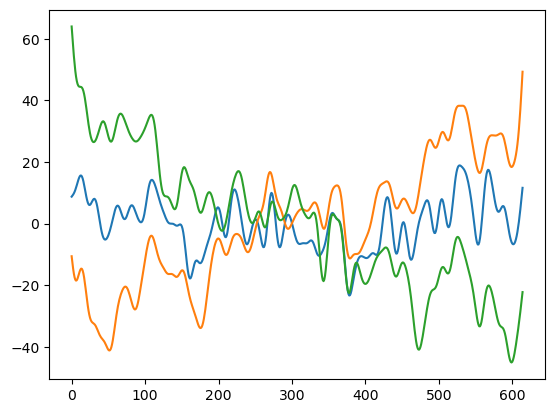

In [34]:
plt.plot(X_train[0, :, 1:4])

(615, 32)
(615, 32)


/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


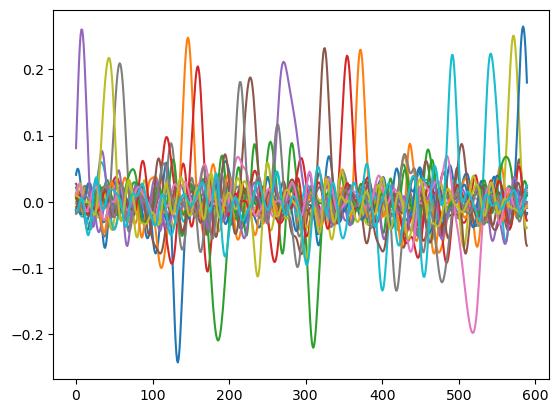

In [54]:
x = X_train[77]
print(x.shape)
tmp = FastICA(max_iter=1000).fit_transform(x)
print(tmp.shape)
# fig, axs = plt.subplots(20)
# for i in range(20):
#     axs[i].plot(tmp[i])
plt.plot(tmp[10:600,0:20]);